In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

In [19]:
import os
import pandas as pd
import numpy as np

# Path to your folder with all images (subfolders per class)
data_dir = "/content/drive/MyDrive/FRCproject/data"

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1  # remaining


In [20]:
filepaths = []
labels = []
splits = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_folder):
        continue

    images = os.listdir(class_folder)
    np.random.shuffle(images)  # shuffle images

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    for i, img in enumerate(images):
        file_path = os.path.join(class_folder, img)
        filepaths.append(file_path)
        labels.append(class_name)

        if i < n_train:
            splits.append("train")
        elif i < n_train + n_val:
            splits.append("val")
        else:
            splits.append("test")


In [21]:
df = pd.DataFrame({
    "filepath": filepaths,
    "label": labels,
    "split": splits
})

df.head()


,filepath,label,split
0,/content/drive/MyDrive/FRCproject/data/pins_Ad...,pins_Adriana Lima,train
1,/content/drive/MyDrive/FRCproject/data/pins_Ad...,pins_Adriana Lima,train
2,/content/drive/MyDrive/FRCproject/data/pins_Ad...,pins_Adriana Lima,train
3,/content/drive/MyDrive/FRCproject/data/pins_Ad...,pins_Adriana Lima,train
4,/content/drive/MyDrive/FRCproject/data/pins_Ad...,pins_Adriana Lima,train


In [22]:
csv_path = "/content/drive/MyDrive/FRCproject/dataset.csv"
df.to_csv(csv_path, index=False)
print(f"CSV saved to: {csv_path}")

CSV saved to: /content/drive/MyDrive/FRCproject/dataset.csv


# The model


In [23]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv("/content/drive/MyDrive/FRCproject/dataset.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

,filepath,label,split
0,/content/drive/MyDrive/FRCproject/data/pins_Pe...,pins_Penn Badgley,train
1,/content/drive/MyDrive/FRCproject/data/pins_Le...,pins_Leonardo DiCaprio,train
2,/content/drive/MyDrive/FRCproject/data/pins_sc...,pins_scarlett johansson,train
3,/content/drive/MyDrive/FRCproject/data/pins_ga...,pins_gal gadot,val
4,/content/drive/MyDrive/FRCproject/data/pins_Am...,pins_Amanda Crew,train


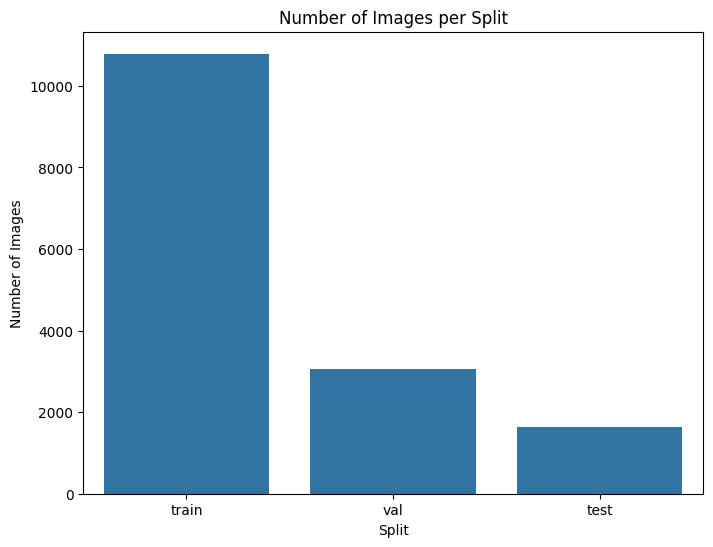

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of images in each split
split_counts = df['split'].value_counts().reset_index()
split_counts.columns = ['split', 'count']

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x='split', y='count', data=split_counts)
plt.title('Number of Images per Split')
plt.xlabel('Split')
plt.ylabel('Number of Images')
plt.show()

In [30]:


train_df = df[df['split'] == 'train']
val_df   = df[df['split'] == 'val']
test_df  = df[df['split'] == 'test']

IMG_SIZE = 160
BATCH_SIZE = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 10787 validated image filenames belonging to 105 classes.
Found 3053 validated image filenames belonging to 105 classes.
Found 1638 validated image filenames belonging to 105 classes.


Original Images:


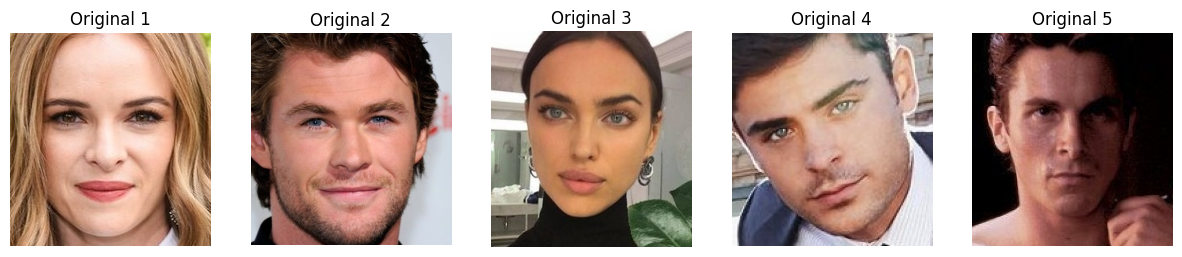


Augmented Images:


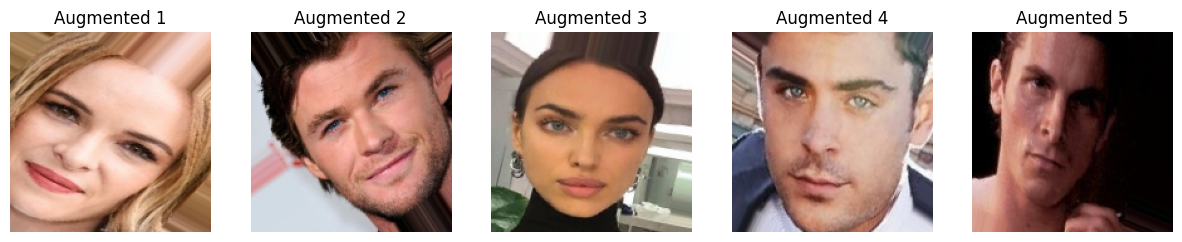

In [31]:

# Get a batch of images from the training generator
images, labels = next(train_generator)

# Select a few images from the batch to display
num_images_to_display = 5
selected_indices = random.sample(range(images.shape[0]), num_images_to_display)

original_filepaths = [train_df.iloc[train_generator.index_array[i]]['filepath'] for i in selected_indices]


print("Original Images:")
plt.figure(figsize=(15, 5))
for i, filepath in enumerate(original_filepaths):
    img = plt.imread(filepath)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"Original {i+1}")
    plt.axis('off')
plt.show()


print("\nAugmented Images:")
plt.figure(figsize=(15, 5))
for i, idx in enumerate(selected_indices):
    # The images variable already contains augmented images from the generator
    augmented_img = images[idx]
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(augmented_img)
    # You might want to get the original label here if needed
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.show()

In [33]:
IMG_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 10


# Model Definition

In [34]:

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

#Define image size and number of classes
rows, cols = 160, 160
num_classes = 105  # Make sure this matches your weights file

# Rebuild the same MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(rows, cols, 3),
    include_top=False,
    weights='imagenet'  # Use ImageNet weights for base
)
base_model.trainable = False
# Get the last layer ('out_relu') output
last_layer = base_model.get_layer('out_relu')
last_layer_output = last_layer.output

# Add your custom layers exactly like in the original model
x = GlobalAveragePooling2D()(last_layer_output)
x = Dropout(0.8)(x)
output = Dense(105, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Load the pretrained weights file
weights_path = '/content/drive/MyDrive/FRCproject/FCWeights.h5'
model.load_weights(weights_path)
print("Weights loaded successfully!")

# Compile the model (optional if you just want inference)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

# Check the model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Weights loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,392,489 (9.13 MB)

 Trainable params: 134,505 (525.41 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Model Evaluation

In [39]:
loss, accuracy = model.evaluate(test_generator, steps=40)

40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 885ms/step - accuracy: 0.9485 - loss: 0.1933


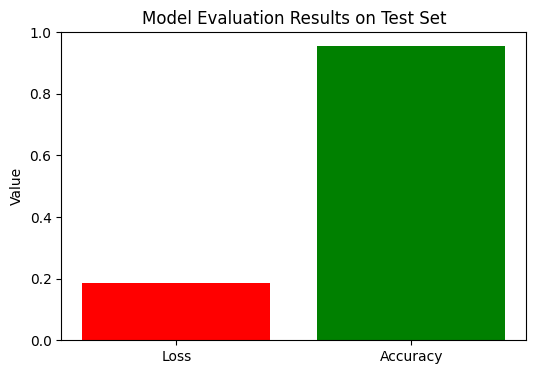

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'loss' and 'accuracy' variables are available from previous execution
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['red', 'green'])
plt.ylabel('Value')
plt.title('Model Evaluation Results on Test Set')
plt.ylim(0, 1) # Assuming accuracy and loss are between 0 and 1
plt.show()

# Prediction Examples

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

#Load an image (replace with your test image path)
img_path = "/content/download.jpeg"   # <-- change to your image file
img = image.load_img(img_path, target_size=(160, 160))  # Resize to match model input
img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

#  Run prediction
predictions = model.predict(img_array)

#  Get the predicted class index and confidence
predicted_class_index = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

# Get the list of class names from the generator
# Make sure test_generator is defined and available in this scope
if 'test_generator' in locals():
    class_names = list(test_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class_index]
    predicted_class_name = predicted_class_name.replace("pins_", "")
    print(f"Predicted class name: {predicted_class_name}")
else:
    print("test_generator is not defined. Cannot get class name.")
    print(f"Predicted class index: {predicted_class_index}")

print(f"Confidence: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted class name: jeff bezos
Confidence: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted class name: Alvaro Morte
Confidence: 1.0000


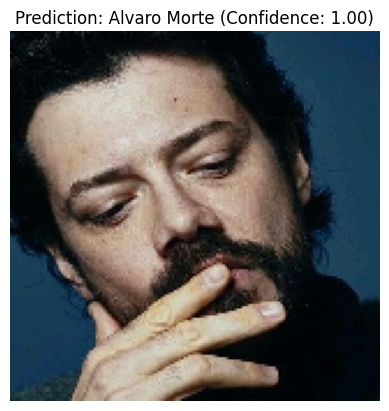

In [43]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load an image (replace with your test image path)
img_path = "/content/Alvaro Morte4_247.jpg"   # <-- change to your image file
img = image.load_img(img_path, target_size=(160, 160))  # Resize to match model input
img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Run prediction
predictions = model.predict(img_array)

# Get the predicted class index and confidence
predicted_class_index = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

# Get the list of class names from the generator
# Make sure test_generator is defined and available in this scope
if 'test_generator' in locals():
    class_names = list(test_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class_index]
    predicted_class_name = predicted_class_name.replace("pins_", "")
    print(f"Predicted class name: {predicted_class_name}")
else:
    print("test_generator is not defined. Cannot get class name.")
    print(f"Predicted class index: {predicted_class_index}")

print(f"Confidence: {confidence:.4f}")

# 4. Display the image with prediction
plt.imshow(img)
plt.title(f"Prediction: {predicted_class_name} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()